
# F.A.I.R. data management in CRC 1333  
## A4: SAXS workflow with AnIML

---

> Authors: Torsten Giess, Selina Itzigehl, Jan Range  
> Last modified: 20.01.2022


### **Abstract** <a class="anchor" name="abstract"></a>

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Integer fringilla justo sed dignissim mattis. Donec nec velit metus. Praesent eget egestas purus. Maecenas congue neque ut magna imperdiet, at ornare nunc iaculis. Vestibulum rhoncus dictum elit non scelerisque. Maecenas sagittis purus ac libero ornare aliquet. Donec nec volutpat justo. Mauris vel massa egestas, imperdiet orci sed, ultricies massa. Sed ornare tempus mi, id tristique lorem elementum eu. Nulla maximus, sapien imperdiet suscipit lobortis, ante sem sodales libero, vitae cursus leo nisi eget dui. Suspendisse potenti. Mauris a magna rutrum libero blandit feugiat. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae; In convallis semper lectus at consequat. Phasellus efficitur fringilla congue. Vestibulum finibus eget augue sit amet interdum.

### **Table of Contents** <a class="anchor" name="table_of_contents"></a>

- [Abstract](#abstract)
- [1&nbsp;&nbsp; Introduction](#introduction)
- [2&nbsp;&nbsp; Workflow](#workflow)
    - [2.1&nbsp;&nbsp; User guide](#user_guide)
    - [2.2&nbsp;&nbsp; Preparation](#preparation)
    - [2.3&nbsp;&nbsp; Conversion to AnIML](#conversion)
    - [2.4&nbsp;&nbsp; Upload preliminary AnIML document to DaRUS](#todarus)
    - [2.5&nbsp;&nbsp; Download preliminary AnIML document from DaRUS](#fromdarus)
    - [2.6&nbsp;&nbsp; Read data from preliminary AnIML document](#read)
    - [2.7&nbsp;&nbsp; Spectral analysis](#analysis)
    - [2.8&nbsp;&nbsp; Results](#results)
    - [2.9&nbsp;&nbsp; Visualisation](#visualisation)
    - [2.10&nbsp;&nbsp; Add analysis and results to final AnIML document](#add)
    - [2.11&nbsp;&nbsp; Create OMEX archive](#omex)
    - [2.12&nbsp;&nbsp; Upload final archive to DaRUS](#upload)
- [3&nbsp;&nbsp; Discussion](#discussion)
- [4&nbsp;&nbsp; Outlook](#outlook)
- [Bibliography](#bibliography)

---
### **1&nbsp;&nbsp; Introduction** <a class="anchor" name="introduction"></a>

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nulla dictum tincidunt ex a semper. Aenean pulvinar risus eget tortor porta malesuada. Praesent id consectetur tellus. Sed eget libero risus. Donec et efficitur enim, ornare pellentesque ante. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Cras gravida arcu eget ipsum aliquam maximus. Donec consectetur tempus interdum. Aliquam ante ligula, ornare vel dui vel, finibus sagittis augue. Donec lacus velit, posuere et feugiat sed, placerat ac nibh. Praesent cursus felis sed gravida elementum. Maecenas non diam sem. Suspendisse sed erat semper, tincidunt turpis in, venenatis mi.

Nullam ac suscipit tellus. Vivamus blandit quis nisi in luctus. Fusce elementum vel est vitae fringilla. Duis gravida iaculis lacinia. Proin accumsan est et nibh tincidunt, id varius arcu sagittis. Integer at nibh dolor. Donec nec scelerisque nulla. Suspendisse lobortis turpis ipsum, eget volutpat tortor dapibus quis. Curabitur et mi turpis. 

---
### **2&nbsp;&nbsp; Workflow** <a class="anchor" name="workflow"></a>

#### **2.1&nbsp;&nbsp; User guide** <a class="anchor" name="user_guide"></a>

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Ut vitae turpis blandit, fringilla tortor eget, finibus mauris. In quis diam sit amet tellus tempor pretium. Vivamus at mauris posuere, hendrerit nisl at, porttitor ex. Nunc eu dui eu purus tempus tempus non nec ipsum. Phasellus viverra id enim at consequat. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Nunc id quam purus. Maecenas bibendum eleifend aliquam. Integer fringilla ipsum eget consequat porta. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Donec eleifend lacus eleifend magna auctor, eget finibus ipsum consectetur. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae.

#### **2.2&nbsp;&nbsp; Preparation** <a class="anchor" name="preparation"></a>

Let us start with the imports of the various Python packages needed!

In [1]:
print("Importing native packages.")
import os
from datetime import date
from pathlib import Path
print ("Done.")

Importing native packages.
Done.


In [2]:
print("Importing PyPI packages.")
from lxml import etree
from pyaniml import AnIMLDocument, Sample, Series, ExperimentStep, Device, IndividualValueSet, SeriesSet, Parameter, Category
from pyDaRUS import Citation, Process, Dataset
from pyDaRUS.metadatablocks.citation import SubjectEnum, IdentifierScheme
print ("Done.")

Importing PyPI packages.
Done.


In [3]:
print("Importing local packages.")
from modules.saxslicer import SAXSlicer
from modules.helperv2 import DataFromAnIML, SpectralAnalysis, Results, Visualisation
from modules.omexwriter import OMEXWriter, OMEXVCard
print("Done.")

Importing local packages.
Done.


Here we create some needed references, namely the environment variables for the upload to DaRUS, a file suffix with the short form of the current data, and some Windows path objects we will need for file handling. Here they are all neatly in one place and easy to find.

In [4]:
os.environ["DATAVERSE_URL"] = "https://darus.uni-stuttgart.de/"
os.environ["DATAVERSE_API_TOKEN"] = "4bd02020-b0b6-4e39-8ef4-23f73ffec1ee"

In [5]:
date_suffix = str(date.today()).replace("-", "")[2:]

In [6]:
CWD = Path.cwd()
PATH_TO_RAW = Path(CWD / "./datasets/raw/")
PATH_TO_PROCESSED = Path(CWD / "./datasets/processed/")
PATH_TO_OMEX = Path(CWD / "./datasets/omex/")

#### **2.3&nbsp;&nbsp; Conversion to AnIML** <a class="anchor" name="conversion"></a>

Using our very own `pyaniml` package, we create an AnIML document, extract the raw data from PDH files with a small *ad hoc* feature called `SAXSlicer` and then we build the AnIML document step by step by creating the respective Python objects required.

In [7]:
animl_doc = AnIMLDocument()

First, we handle the calibration measurement:

In [8]:
calibration_raw = SAXSlicer(str(PATH_TO_RAW / "CholPal_210713[7]1.pdh"))
calibration_data = calibration_raw.extract_data()
calibration_metadata = calibration_raw.extract_metadata(str(PATH_TO_PROCESSED / "CholPal_metadata.xml"))

Loading metadata from existing file: C:\Users\ac138949\Documents\GitHub\SAXS-workflow\notebooks\datasets\processed\CholPal_metadata.xml.


In [9]:
calibration_sample = Sample(
    id="calibration",
    name="Cholesteryl palmitate"
)
animl_doc.add_sample(calibration_sample)
calibration_experiment = ExperimentStep(
    name="calibration measurement",
    experiment_step_id="step00"
)
calibration_experiment.add_sample_reference(
    sample=calibration_sample,
    role="measured",
    sample_purpose="destroyed"
)
calibration_device = Device(
    name="Anton Parr SAXSess",
    firmware_version="",
    serial_number=""
)
calibration_experiment.add_method(calibration_device)
calibration_q_values = IndividualValueSet(
    calibration_data["scattering_vector"].tolist()
)
calibration_q = Series(
    name="scattering vector",
    id="cal_q",
    data=calibration_q_values,
    data_type="float32",
    dependency="dependent",
    plot_scale="none"
)
calibration_i_values = IndividualValueSet(
    calibration_data["counts_per_area"].tolist()
)
calibration_i = Series(
    name="counts per area",
    id="cal_i",
    data=calibration_i_values,
    data_type="float32",
    dependency="dependent",
    plot_scale="none"
)
calibration_set = SeriesSet(
    name="1D SAXS",
    series=[calibration_q, calibration_i]
)
calibration_experiment.add_result(calibration_set)
animl_doc.add_experiment_step(calibration_experiment)

Then we handle the sample measurement:

In [10]:
sample_file = SAXSlicer(str(PATH_TO_RAW / "SI06_210623[7].pdh"))
sample_data = sample_file.extract_data()
sample_metadata = sample_file.extract_metadata(str(PATH_TO_PROCESSED / "SI06_210623_metadata.xml"))

Loading metadata from existing file: C:\Users\ac138949\Documents\GitHub\SAXS-workflow\notebooks\datasets\processed\SI06_210623_metadata.xml.


In [11]:
sample_sample = Sample(
    id="sample",
    name="SI06_210623"
)
animl_doc.add_sample(sample_sample)
sample_experiment = ExperimentStep(
    name="sample measurement",
    experiment_step_id="step01"
)
sample_experiment.add_sample_reference(
    sample=sample_sample,
    role="measured",
    sample_purpose="destroyed"
)
sample_device = Device(
    name="Anton Parr SAXSess",
    firmware_version="",
    serial_number=""
)
sample_experiment.add_method(sample_device)
sample_q_values = IndividualValueSet(
    sample_data["scattering_vector"].tolist()
)
sample_q = Series(
    name="scattering vector",
    id="sam_q",
    data=sample_q_values,
    data_type="float32",
    dependency="dependent",
    plot_scale="none"
)
sample_i_values = IndividualValueSet(
    sample_data["counts_per_area"].tolist()
)
sample_i = Series(
    name="counts per area",
    id="sam_i",
    data=sample_i_values,
    data_type="float32",
    dependency="dependent",
    plot_scale="none"
)
sample_set = SeriesSet(
    name="1D SAXS",
    series=[sample_q, sample_i]
)
sample_experiment.add_result(sample_set)
animl_doc.add_experiment_step(sample_experiment)

Serializing the AnIML document to an XML string and finally saving it to the actual *.animl* file:

In [12]:
xml_string = animl_doc.toXML()

In [13]:
path_to_AnIML_file = Path(PATH_TO_PROCESSED / f"A4_SAXS_{date_suffix}.animl")

In [14]:
with path_to_AnIML_file.open("w") as wf:
    wf.write(xml_string)
del animl_doc
print(f"Successfully converted and saved PDH to AnIML.")

Successfully converted and saved PDH to AnIML.


#### **2.4&nbsp;&nbsp; Upload preliminary AnIML document to DaRUS** <a class="anchor" name="DaRUS1"></a>

Using `pyDaRUS`, we can access our Dataverse installation directly from our notebook using simple and easily understandable syntax. First we add the required metadata block (consisting at least of titel, auhor, contact, description, and subject), then we upload to DaRUS and finally we download the metadata block again to see if everything turned out alright.

In [15]:
cit_preliminary = Citation(title=f"A4 SAXS preliminary {date.today()}")
proc_preliminary = Process()

In [16]:
cit_preliminary.add_author("Giess, Torsten", "University of Stuttgart", IdentifierScheme.orcid, "0000-0002-8512-8606")
cit_preliminary.add_author("Itzigehl, Selina", "University of Stuttgart")
cit_preliminary.add_author("Range, Jan", "University of Stuttgart", IdentifierScheme.orcid, "0000-0001-6478-1051")
cit_preliminary.add_contact("Giess, Torsten", "University of Stuttgart", "torsten.giess@ibtb.uni-stuttgart.de")
cit_preliminary.add_description("Test upload of the preliminary A4 SAXS AnIML document.", f"{date.today()}")
cit_preliminary.subject = [SubjectEnum.chemistry]

proc_preliminary.add_processing_methods("SAXS", "1D SAXS Experiment", "q, I")
proc_preliminary.add_method_parameters("scattering vector", "q")
proc_preliminary.add_method_parameters("counts per area", "I")
proc_preliminary.add_software(name="Jupyter Notebook", version="2022-01-11", url="https://github.com/FAIRChemistry/SAXS-workflow", license="BSD-3")
proc_preliminary.add_instruments(name="Anton Parr SAXSess", software="SAXSQuant", location="IPC")

In [17]:
dataset_preliminary = Dataset()
dataset_preliminary.add_metadatablock(cit_preliminary)
dataset_preliminary.add_metadatablock(proc_preliminary)

In [18]:
# dataset_doi_preliminary = dataset_preliminary.upload("torsten_playground", filenames=[str(PATH_TO_PROCESSED / f"A4_SAXS_{date_suffix}.animl")])
dataset_doi_preliminary = "doi:10.18419/darus-2454"

#### ***2.5&nbsp;&nbsp; Download preliminary AnIML document from DaRUS*** <a class="anchor" name="DaRUS2"></a>

**Currently still pending**, as the feature for downloading files is still in development.  
Let's take a look at the uploaded metadata block instead.

In [19]:
dataset_preliminary_metadata_block = Dataset.from_dataverse_doi(dataset_doi_preliminary)
print(dataset_preliminary_metadata_block.json(indent=2))

{
  "metadatablocks": {
    "citation": {
      "title": "A4 SAXS preliminary 2022-01-20",
      "subtitle": null,
      "alternative_title": null,
      "alternative_url": null,
      "subject": [
        "Chemistry"
      ],
      "notes": null,
      "language": null,
      "production_date": null,
      "production_place": null,
      "distribution_date": null,
      "depositor": null,
      "deposit_date": null,
      "kind_of_data": null,
      "related_material": null,
      "related_datasets": null,
      "other_references": null,
      "data_sources": null,
      "origin_of_sources": null,
      "characteristic_of_sources_noted": null,
      "documentation_and_access_to_sources": null,
      "did_it_work": null,
      "explanation": null,
      "author": [
        {
          "name": "Giess, Torsten",
          "affiliation": "University of Stuttgart",
          "identifier_scheme": "ORCID",
          "identifier": "0000-0002-8512-8606"
        },
        {
          "name": "

#### **2.6&nbsp;&nbsp; Read data from preliminary AnIML document** <a class="anchor" name="read"></a>

As the download feature is still in development, the AnIML document is curently loaded from local source, not from DaRUS.  
Also AnIML is currently still read via `lxml.etree`, which is depracated as `pyaniml` also provides the means to read AnIML. Will be implemented soon!

In [20]:
with path_to_AnIML_file.open("rb") as rbf:
    root = etree.fromstring(rbf.read())

In [21]:
cal_q = [ float(F.text) for F in root.iterfind(".//Series[@seriesID='cal_q']/IndividualValueSet/F") ]
cal_i = [ float(F.text) for F in root.iterfind(".//Series[@seriesID='cal_i']/IndividualValueSet/F") ]
sam_q = [ float(F.text) for F in root.iterfind(".//Series[@seriesID='sam_q']/IndividualValueSet/F") ]
sam_i = [ float(F.text) for F in root.iterfind(".//Series[@seriesID='sam_i']/IndividualValueSet/F") ]

print(f"Successfully read from AnIML.")

Successfully read from AnIML.


In [22]:
data = DataFromAnIML(cal_q, cal_i, sam_q, sam_i)

In [23]:
calibration_q = data.format_calibration_data("q")
calibration_i = data.format_calibration_data("i")
calibration_peaks = data.format_calibration_data("peaks")

sample_q = data.format_sample_data("q")
sample_i = data.format_sample_data("i")
sample_for_plot = data.format_sample_data("plot")

print(f"Successfully created Pandas dataframes")

Successfully created Pandas dataframes


#### **2.7&nbsp;&nbsp; Analysis** <a class="anchor" name="analysis"></a>

Back-end analysis script provided by Selina. Works fine but still needs to be more interactive.

Plot and Lorentz fit successful. Best fit for q: [1.17560174, 2.34572076, 3.51747273].


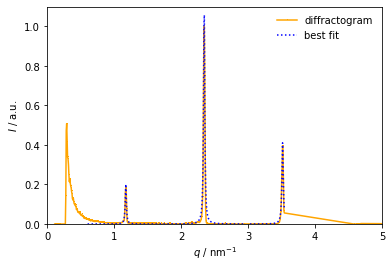

In [24]:
analysis = SpectralAnalysis(calibration_q, calibration_i, calibration_peaks)
analysis.create_plot("orange")
lorentz_calibration_q = analysis.do_lorentz()

print(f"Plot and Lorentz fit successful. Best fit for q: {lorentz_calibration_q}.")

#### **2.8&nbsp;&nbsp; Results** <a class="anchor" name="results"></a>

Back-end script for calculations provided by Selina. Also requires interactive features.

In [25]:
results = Results(sample_q, sample_for_plot, lorentz_calibration_q)
calculated = results.do_calculations() 

print(f"Data evaluation successful.")

Data evaluation successful.


#### **2.9&nbsp;&nbsp; Visualisation** <a class="anchor" name="visualisation"></a>

Back-end visualisation script provided by Selina. Again, requires interactive features.

In [26]:
visualiser = Visualisation(str(PATH_TO_RAW), sample_for_plot, calculated, str(PATH_TO_PROCESSED))

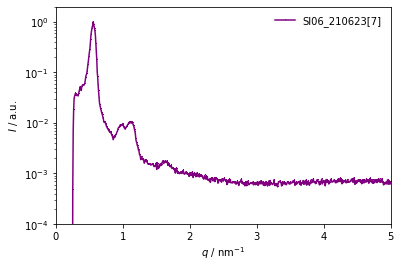

Successfully saved results to .tsv and plots to .png.


In [27]:
visualiser.write_to_tsv(f"A4_SAXS_{date_suffix}.tsv")
visualiser.plot_and_save_data("purple")

print(f"Successfully saved results to .tsv and plots to .png.")

#### **2.10&nbsp;&nbsp; Add analysis and results to final AnIML document** <a class="anchor" name="add"></a>

Now we can re-open our preliminary AnIML document (this time with `pyaniml`, as should be) and start adding the new (meta-)data from the spectral analysi, calculations, and visualisation to it!

In [28]:
with path_to_AnIML_file.open("r") as rf:
    xml_string = rf.read()
    animl_doc = AnIMLDocument.fromXMLString(xml_string)

In [29]:
data_eval = ExperimentStep(
    name="Data evaluation",
    experiment_step_id="step02"
)

In [30]:
analysis_device = Device(
    name="Microsoft Windows 10 Pro Personal Computer",
    firmware_version="10.0.19044",
    serial_number=""
)
data_eval.add_method(analysis_device)

In [31]:
tool_01 = Parameter(
    name="Analysis tool",
    parameter_type="String",
    value="Python 3.9.7"
)
tool_02 = Parameter(
    name="Analysis tool",
    parameter_type="String",
    value="Jupyter Lab 6.1.7 "
)
analysis_tools = Category(    
    name="Analysis tools",
    parameters=[tool_01, tool_02]
)
data_eval.add_method(analysis_tools)

In [32]:
step_01 = Parameter(
    name="Analysis step",
    parameter_type="String",
    value="Spectral analysis"
)
step_02 = Parameter(
    name="Analysis step",
    parameter_type="String",
    value="Calculations"
)
step_03 = Parameter(
    name="Analysis step",
    parameter_type="String",
    value="Visualisation"
)
analysis_steps = Category(
    name="Analysis steps",
    parameters=[step_01, step_02, step_03]
)
data_eval.add_method(analysis_steps)

In [33]:
animl_doc.add_experiment_step(data_eval)
xml_string = animl_doc.toXML()

In [34]:
with path_to_AnIML_file.open("w") as wf:
    wf.write(xml_string)
print(f"Successfully updated AnIML document.")

Successfully updated AnIML document.


#### **2.11&nbsp;&nbsp; Create OMEX archive** <a class="anchor" name="omex"></a>

As it is often advantageous to add raw data files, images, an other formats to a dataset, the AnIML document is bundled with said additional files in form of a special ZIP format called OMEX. It is self-describing through addition of a *manifest.xml* file and a *metadata.rdf* file for every file contained in the archive. This ensures maximum interoberability of the contents. Here, we build said archive using the `python-libcombine` package, adding the raw PDH data files, the PNG images, and results in TSV format.

In [35]:
writer = OMEXWriter()

In [36]:
vcard_giess = OMEXVCard("Giess", "Torsten", "torsten.giess@ibtb.uni-stuttgart.de", "University of Stuttgart").get_vcard()
vcard_itzigehl = OMEXVCard("Itzigehl", "Selina", organization="University of Stuttgart").get_vcard()
vcard_range = OMEXVCard("Range", "Jan", organization="University of Stuttgart").get_vcard()

In [37]:
writer.add_AnIML(str(PATH_TO_PROCESSED / f"A4_SAXS_{date_suffix}.animl"), vcard_giess, vcard_itzigehl, vcard_range)
writer.add_data(str(PATH_TO_RAW), ["pdh"], vcard_itzigehl)
writer.add_data(str(PATH_TO_PROCESSED), ["png", "tsv"], vcard_giess, vcard_itzigehl)

In [38]:
writer.create_omex(str(PATH_TO_OMEX / f"A4_SAXS_{date_suffix}.omex"))

#### **2.12&nbsp;&nbsp; Upload final archive to DaRUS** <a class="anchor" name="upload"></a>

Same as before, let's build the metadata block and upload the OMEX archive to DaRUS.

In [39]:
cit_final = Citation(title=f"A4 SAXS final {date.today()}")
proc_final = Process()

In [40]:
cit_final.add_author("Giess, Torsten", "University of Stuttgart", IdentifierScheme.orcid, "0000-0002-8512-8606")
cit_final.add_author("Itzigehl, Selina", "University of Stuttgart")
cit_final.add_author("Range, Jan", "University of Stuttgart", IdentifierScheme.orcid, "0000-0001-6478-1051")
cit_final.add_contact("Giess, Torsten", "University of Stuttgart", "torsten.giess@ibtb.uni-stuttgart.de")
cit_final.add_description("Test upload of the final SAXS OMEX archive.", f"{date.today()}")
cit_final.subject = [SubjectEnum.chemistry]

proc_final.add_processing_methods("SAXS", "1D SAXS Experiment", "q, I")
proc_final.add_method_parameters("scattering vector", "q")
proc_final.add_method_parameters("counts per area", "I")
proc_final.add_software(name="Jupyter Notebook", version="2022-01-11", url="https://github.com/FAIRChemistry/SAXS-workflow", license="BSD-3")
proc_final.add_instruments(name="Anton Parr SAXSess", software="SAXSQuant", location="IPC")

In [41]:
dataset_final = Dataset()
dataset_final.add_metadatablock(cit_final)
dataset_final.add_metadatablock(proc_final)

In [42]:
# dataset_doi_final = dataset_final.upload("torsten_playground", filenames=[str(PATH_TO_OMEX / f"A4_SAXS_{date_suffix}.omex")])
dataset_doi_final = "doi:10.18419/darus-2455"

Let's check the test repository for our two new datasets, the preliminary AnIML document and the final OMEX archive!

In [1]:
import webbrowser
url = "https://darus.uni-stuttgart.de/dataverse.xhtml?alias=torsten_playground"
webbrowser.open(url)

True

In [44]:
dataset_final_metadata_block = Dataset.from_dataverse_doi(dataset_doi_final)
print(dataset_final_metadata_block.json(indent=2))

{
  "metadatablocks": {
    "citation": {
      "title": "A4 SAXS final 2022-01-20",
      "subtitle": null,
      "alternative_title": null,
      "alternative_url": null,
      "subject": [
        "Chemistry"
      ],
      "notes": null,
      "language": null,
      "production_date": null,
      "production_place": null,
      "distribution_date": null,
      "depositor": null,
      "deposit_date": null,
      "kind_of_data": null,
      "related_material": null,
      "related_datasets": null,
      "other_references": null,
      "data_sources": null,
      "origin_of_sources": null,
      "characteristic_of_sources_noted": null,
      "documentation_and_access_to_sources": null,
      "did_it_work": null,
      "explanation": null,
      "author": [
        {
          "name": "Giess, Torsten",
          "affiliation": "University of Stuttgart",
          "identifier_scheme": "ORCID",
          "identifier": "0000-0002-8512-8606"
        },
        {
          "name": "Itzige

---
### **3&nbsp;&nbsp; Discussion** <a class="anchor" name="discussion"></a>

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nullam sed tincidunt elit, quis convallis massa. Sed tempor semper condimentum. Curabitur maximus, eros id ullamcorper ullamcorper, mi dolor rhoncus magna, ac gravida erat urna a nisl. Aenean posuere ex pellentesque sem luctus, eget dapibus mauris aliquam. Praesent viverra imperdiet convallis. Donec tristique ligula sodales nibh consequat, imperdiet aliquam nisi vestibulum. Nam sagittis arcu eu blandit laoreet. Phasellus sodales eros vel mauris pellentesque vulputate. Donec rutrum, purus non aliquam interdum, dolor erat pharetra sapien, sit amet dignissim mi quam eget urna. Aenean vel dictum mauris, in ultricies elit. Phasellus iaculis massa venenatis neque scelerisque commodo. Sed rutrum lorem nec augue tincidunt commodo. Morbi semper, nibh eget ullamcorper mollis, massa purus lobortis nunc, vitae cursus quam justo vel nisi. Quisque dignissim malesuada urna quis tempus. Nulla orci eros, blandit nec est a, accumsan tincidunt massa. Nunc fringilla nunc tempus dui scelerisque, sed suscipit mi efficitur.

Cras pellentesque magna ut est viverra, vel mattis diam consectetur. Maecenas eleifend ipsum odio, non egestas nibh laoreet quis. Mauris non luctus mi. Sed felis enim, fringilla nec mi eget, venenatis gravida ipsum. In sed aliquet lectus, ac ornare lectus. Vivamus eu sapien odio. Aliquam gravida id eros ac lobortis. Duis quis sodales lectus, at sollicitudin sapien. Sed sollicitudin enim eget tortor bibendum, sit amet maximus felis volutpat.

Aliquam elit lorem, pulvinar ut erat non, tempor fermentum leo. Duis magna risus, rutrum eu commodo laoreet, tempus ac nisi. Fusce sit amet pharetra enim. Etiam dui nisi, efficitur euismod sodales ut, maximus et quam. Integer justo lorem, gravida eget dictum a, elementum sit amet mi. Proin vel purus erat. Quisque blandit tempus leo. Donec tempus pellentesque lectus, at lacinia nunc efficitur eget. Aenean sem ante, bibendum vel erat id, dictum vulputate est. Praesent tempor efficitur semper. 

---
### **4&nbsp;&nbsp; Outlook** <a class="anchor" name="outlook"></a>

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Aenean rutrum quam ac maximus feugiat. Ut vestibulum sit amet risus id dictum. Aenean lorem mauris, elementum non laoreet vel, dignissim ac risus. Vestibulum fermentum arcu id ante placerat, id euismod lectus sagittis. Proin tristique vestibulum quam, et placerat orci consequat sit amet. Vivamus volutpat ante ac massa pulvinar, at dapibus enim tempus. In et commodo urna, in ornare massa. Proin sit amet dui at arcu finibus aliquam et eu quam. Fusce gravida, arcu a iaculis lacinia, nibh tortor molestie purus, in pulvinar augue turpis ut neque. Sed metus purus, convallis et dapibus sit amet, placerat vel eros. Aenean quis ultricies enim. Mauris vitae diam risus. Duis eu dolor dolor. Sed gravida viverra ante, non gravida lectus malesuada sed.

Nulla nec tincidunt tortor, non cursus lorem. Mauris eu urna vel justo feugiat feugiat vel ac nisl. Donec eget varius est. Etiam vestibulum auctor quam. Curabitur laoreet est et malesuada ullamcorper. Cras efficitur odio vitae porttitor semper. Curabitur suscipit, dui vitae auctor condimentum, tortor mauris congue odio, et lacinia diam dui ut neque. Integer semper elit ultricies orci maximus, non convallis diam varius. Nulla malesuada enim in tortor tristique mollis. Maecenas ac gravida nisl. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Vivamus quis rhoncus magna. Vestibulum rutrum, leo sit amet dictum maximus, ex metus volutpat massa, at feugiat est est nec quam. Vestibulum ultrices ullamcorper turpis at semper. Phasellus venenatis orci cursus ipsum sollicitudin, ut consequat lectus egestas. 

---
### **Bibliography** <a class="anchor" name="bibliography"></a>

[1] Lorem ipsum dolor sit amet, consectetur adipiscing elit.  
[2] Nullam at dui vel ante bibendum maximus.  
[3] Nullam aliquet nisi ullamcorper, fringilla neque vel, sollicitudin velit.  
[4] Mauris sit amet nisi ac lacus semper gravida.